<a href="https://colab.research.google.com/github/Rishpraveen/Gmail-Calendar-Query-Classifier/blob/main/Gmail_Calendar_Query_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Uninstall existing installations of jax and transformers to ensure a clean install
!pip uninstall -y jax jaxlib transformers

# Install jax and transformers, which will pull in compatible dependencies including numpy
# We are specifying the CPU version of jaxlib for broader compatibility.
!pip install --upgrade jax jaxlib[cpu] transformers

# Add back other necessary libraries explicitly if not covered by the above installs
!pip install --upgrade pandas numpy scikit-learn seaborn matplotlib datasets dateparser

# Ensure all necessary modules are imported after potential reinstall
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
import dateparser
import dateparser.search
from datetime import datetime, timedelta
import calendar
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Found existing installation: jax 0.6.1
Uninstalling jax-0.6.1:
  Successfully uninstalled jax-0.6.1
Found existing installation: jaxlib 0.6.1
Uninstalling jaxlib-0.6.1:
  Successfully uninstalled jaxlib-0.6.1
Found existing installation: transformers 4.52.4
Uninstalling transformers-4.52.4:
  Successfully uninstalled transformers-4.52.4
  Using cached jax-0.6.1-py3-none-any.whl.metadata (13 kB)
  Using cached transformers-4.52.4-py3-none-any.whl.metadata (38 kB)
  Using cached jaxlib-0.6.1-cp311-cp311-manylinux2014_x86_64.whl.metadata (1.2 kB)
Using cached jax-0.6.1-py3-none-any.whl (2.4 MB)
Using cached transformers-4.52.4-py3-none-any.whl (10.5 MB)
Using cached jaxlib-0.6.1-cp311-cp311-manylinux2014_x86_64.whl (89.1 MB)


/usr/local/lib/python3.11/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.5.1 is installed, but it is not compatible with the installed jaxlib version 0.6.1, so it will not be used.
  warnings.warn(


Using device: cpu


In [ ]:
# =================================================================
# EXPANDED DATASET WITH MORE EXAMPLES AND EDGE CASES
# =================================================================

data = [
    # ----- Gmail Queries (Label 0) -----
    {"text": "Find emails with PDF attachments", "label": 0},
    {"text": "Show me unread messages in my inbox", "label": 0},
    {"text": "Search for emails from Sarah about the project proposal", "label": 0},
    {"text": "Find messages with subject line 'quarterly report'", "label": 0},
    {"text": "Show all emails I've received from marketing@company.com", "label": 0},
    {"text": "Find emails with large attachments", "label": 0},
    {"text": "Search for emails I starred last week", "label": 0},
    {"text": "Show me all emails in my Promotions tab", "label": 0},
    {"text": "Find messages with the label 'Urgent'", "label": 0},
    {"text": "Show me my drafts", "label": 0},
    {"text": "What emails did I send yesterday?", "label": 0},
    {"text": "Locate emails marked as important", "label": 0},
    {"text": "Show me the email thread with Alice", "label": 0},
    {"text": "Find emails containing the keyword budget", "label": 0},
    {"text": "Retrieve emails with audio files", "label": 0},
    {"text": "Find my conversation with HR last week", "label": 0},
    {"text": "List emails from John since January", "label": 0},
    {"text": "Open all promotional emails", "label": 0},
    {"text": "Find all messages I sent from my phone", "label": 0},
    {"text": "Show email attachments from March", "label": 0},
    {"text": "Search archived emails from 2020", "label": 0},
    {"text": "Look for newsletters I subscribed to", "label": 0},
    {"text": "Retrieve all flagged messages", "label": 0},
    {"text": "Show all starred threads", "label": 0},
    {"text": "Find the email with the resume attached", "label": 0},
    {"text": "Check spam messages from last week", "label": 0},
    {"text": "Find the email with subject 'Interview Confirmation'", "label": 0},
    {"text": "What did Jack email me on Friday?", "label": 0},
    {"text": "Find emails mentioning flight tickets", "label": 0},
    {"text": "Show email history with my manager", "label": 0},
    {"text": "Search sent items for last month", "label": 0},
    {"text": "Emails with Excel sheets attached", "label": 0},
    {"text": "Show emails marked unread", "label": 0},
    {"text": "Open recent email threads with David", "label": 0},
    {"text": "Retrieve all job offer letters", "label": 0},
    {"text": "Find messages from noreply@accounts.google.com", "label": 0},
    {"text": "Emails I sent on Sunday", "label": 0},
    {"text": "Locate email with the contract document", "label": 0},
    {"text": "Search inbox for feedback emails", "label": 0},
    {"text": "Get the list of attachments sent by finance team", "label": 0},
    {"text": "Find all responses to my resignation mail", "label": 0},
    {"text": "Emails from LinkedIn notifications", "label": 0},
    {"text": "Show all bounced emails", "label": 0},
    {"text": "Get me all survey emails", "label": 0},
    {"text": "Show emails with calendar invites", "label": 0},
    {"text": "Find all emails tagged as personal", "label": 0},
    {"text": "Retrieve messages that I sent but weren't delivered", "label": 0},
    {"text": "Show all filtered messages", "label": 0},
    {"text": "Search messages that include spreadsheet", "label": 0},
    {"text": "Open the latest email from yesterday", "label": 0},
    # Additional Gmail examples for better balance
    {"text": "Forward this email to my team", "label": 0},
    {"text": "Reply to all recipients in this thread", "label": 0},
    {"text": "Move these emails to trash", "label": 0},
    {"text": "Create a filter for these types of emails", "label": 0},
    {"text": "Mark all emails from this sender as read", "label": 0},
    {"text": "Find emails larger than 10MB", "label": 0},
    {"text": "Show me emails in my Social tab", "label": 0},
    {"text": "Find emails with .zip attachments", "label": 0},
    {"text": "Search for emails containing invoice", "label": 0},
    {"text": "Show me emails I labeled as work", "label": 0},
    {"text": "Find emails sent to multiple recipients", "label": 0},
    {"text": "Retrieve emails with high priority", "label": 0},

    # ----- Calendar Queries (Label 1) -----
    {"text": "When is my next meeting with the design team?", "label": 1},
    {"text": "Show me all events scheduled for next Tuesday", "label": 1},
    {"text": "Find appointments with Dr. Johnson", "label": 1},
    {"text": "When did I schedule the quarterly review?", "label": 1},
    {"text": "Show me all recurring meetings", "label": 1},
    {"text": "Find events where I'm marked as optional", "label": 1},
    {"text": "When is the marketing presentation scheduled?", "label": 1},
    {"text": "Show me all-day events in May", "label": 1},
    {"text": "Find meetings I haven't responded to yet", "label": 1},
    {"text": "When is the team lunch scheduled for?", "label": 1},
    {"text": "Show my agenda for today", "label": 1},
    {"text": "What do I have planned next week?", "label": 1},
    {"text": "Check if I'm free on Friday", "label": 1},
    {"text": "List all birthdays this month", "label": 1},
    {"text": "What's on my calendar for tomorrow?", "label": 1},
    {"text": "Display all meetings with Alex", "label": 1},
    {"text": "Find my events in July", "label": 1},
    {"text": "Do I have anything on 10th June?", "label": 1},
    {"text": "List calendar invites I declined", "label": 1},
    {"text": "Show overlapping meetings this week", "label": 1},
    {"text": "Display appointments tagged as urgent", "label": 1},
    {"text": "Find calendar items starting before 9 AM", "label": 1},
    {"text": "Show me canceled meetings", "label": 1},
    {"text": "List video call meetings", "label": 1},
    {"text": "When did I last meet with product team?", "label": 1},
    {"text": "Check my calendar for next month", "label": 1},
    {"text": "List upcoming holidays", "label": 1},
    {"text": "Display travel plans in my calendar", "label": 1},
    {"text": "Show events added in the past week", "label": 1},
    {"text": "Find reminders I've set", "label": 1},
    {"text": "Show upcoming webinars", "label": 1},
    {"text": "Display meetings without location", "label": 1},
    {"text": "Find calendar entries shared with team", "label": 1},
    {"text": "Check availability for 3 PM tomorrow", "label": 1},
    {"text": "When is the next client review meeting?", "label": 1},
    {"text": "Do I have any training sessions?", "label": 1},
    {"text": "Meetings from 9th to 15th of April", "label": 1},
    {"text": "Show me my calendar events from today", "label": 1},
    {"text": "What events are marked as tentative?", "label": 1},
    {"text": "Display past events from last month", "label": 1},
    {"text": "Show weekly sync meetings", "label": 1},
    {"text": "Find all 1-on-1 meetings", "label": 1},
    {"text": "List events hosted by me", "label": 1},
    {"text": "Do I have a meeting with Jane this week?", "label": 1},
    {"text": "Find all meetings related to Q3 planning", "label": 1},
    {"text": "Check calendar conflicts on Monday", "label": 1},
    {"text": "What events did I cancel last week?", "label": 1},
    {"text": "List all all-hands meetings", "label": 1},
    {"text": "What's on my calendar for evening today?", "label": 1},
    {"text": "Show agenda shared by marketing", "label": 1},
    {"text": "Calendar entries I've been invited to", "label": 1},
    # Additional Calendar examples
    {"text": "Book a conference room for tomorrow", "label": 1},
    {"text": "Schedule a meeting with the client", "label": 1},
    {"text": "Block my calendar for vacation days", "label": 1},
    {"text": "Set a reminder for the presentation", "label": 1},
    {"text": "Find my meetings for June 2025", "label": 1},
    {"text": "When is my dentist appointment?", "label": 1},
    {"text": "Show me my workout schedule", "label": 1},
    {"text": "What meetings do I have before lunch?", "label": 1},
    {"text": "Find my recurring standup meetings", "label": 1},
    {"text": "Check my schedule for this afternoon", "label": 1},

    # ----- Challenging Edge Cases -----
    {"text": "What did I discuss yesterday?", "label": 0},  # Could be email or meeting, but more likely email
    {"text": "Find my conversation from last week", "label": 0},  # Email conversation
    {"text": "What's on my schedule for last Friday?", "label": 1},  # Calendar
    {"text": "Do I have anything important tomorrow?", "label": 1},  # Calendar
    {"text": "Find my communication with David", "label": 0},  # Email communication
    {"text": "What happened on March 3rd?", "label": 1},  # Calendar events
    {"text": "Show my last message from yesterday", "label": 0},  # Email message
    {"text": "What are my updates for today?", "label": 1},  # Calendar updates/agenda
    {"text": "Remind me what I did Monday", "label": 1},  # Calendar activities
    {"text": "Where's my latest message?", "label": 0},  # Email message
    {"text": "Check my notifications from yesterday", "label": 0},  # Email notifications
    {"text": "What's coming up this week?", "label": 1},  # Calendar events
    {"text": "Find my recent interactions with Sarah", "label": 0},  # Email interactions
    {"text": "What do I need to prepare for tomorrow?", "label": 1},  # Calendar preparation
    {"text": "Show me my correspondence with HR", "label": 0},  # Email correspondence
]

print(f"Total dataset size: {len(data)}")

# Create DataFrame and check balance
df = pd.DataFrame(data)
print(f"Label distribution:")
print(df['label'].value_counts())
print(f"Gmail queries: {sum(df['label'] == 0)}")
print(f"Calendar queries: {sum(df['label'] == 1)}")

Total dataset size: 138
Label distribution:
label
0    70
1    68
Name: count, dtype: int64
Gmail queries: 70
Calendar queries: 68


In [ ]:

# =================================================================
# DATA PREPARATION WITH BETTER SPLITS
# =================================================================

# Split the data
df_train, df_temp = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label'])
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42, stratify=df_temp['label'])

print(f"\nData splits:")
print(f"Train size: {len(df_train)} (Gmail: {sum(df_train['label'] == 0)}, Calendar: {sum(df_train['label'] == 1)})")
print(f"Validation size: {len(df_val)} (Gmail: {sum(df_val['label'] == 0)}, Calendar: {sum(df_val['label'] == 1)})")
print(f"Test size: {len(df_test)} (Gmail: {sum(df_test['label'] == 0)}, Calendar: {sum(df_test['label'] == 1)})")


Data splits:
Train size: 96 (Gmail: 49, Calendar: 47)
Validation size: 21 (Gmail: 10, Calendar: 11)
Test size: 21 (Gmail: 11, Calendar: 10)


In [ ]:
# =================================================================
# MODEL SETUP AND TRAINING
# =================================================================

# Try DistilBERT for faster training on small dataset
MODEL_NAME = "distilbert-base-uncased"  # Lighter and faster than BERT/RoBERTa

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

# Convert to HuggingFace datasets and tokenize
train_dataset = Dataset.from_pandas(df_train)
val_dataset = Dataset.from_pandas(df_val)
test_dataset = Dataset.from_pandas(df_test)

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_val = val_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

# Remove unnecessary columns
tokenized_train = tokenized_train.remove_columns(["text", "__index_level_0__"])
tokenized_val = tokenized_val.remove_columns(["text", "__index_level_0__"])
tokenized_test = tokenized_test.remove_columns(["text", "__index_level_0__"])

# Set format
tokenized_train.set_format("torch")
tokenized_val.set_format("torch")
tokenized_test.set_format("torch")

# Training arguments - optimized for small dataset
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=5,  # Reduced epochs for small dataset
    per_device_train_batch_size=8,  # Increased batch size
    per_device_eval_batch_size=8,
    warmup_steps=10,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",
    seed=42,
    learning_rate=2e-5,  # Standard learning rate for fine-tuning
)

# Evaluation metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics,
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/96 [00:00<?, ? examples/s]

Map:   0%|          | 0/21 [00:00<?, ? examples/s]

Map:   0%|          | 0/21 [00:00<?, ? examples/s]

In [ ]:
# =================================================================
# TRAINING THE MODEL (THIS WAS MISSING IN ORIGINAL CODE)
# =================================================================

print("Starting training...")
trainer.train()

Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.695300,0.667929,0.619048,0.542857,0.779449,0.619048
2,0.647100,0.532013,0.904762,0.904762,0.904762,0.904762
3,0.532400,0.354951,0.952381,0.952163,0.956349,0.952381
4,0.378000,0.262184,0.952381,0.952163,0.956349,0.952381
5,0.198000,0.235943,0.952381,0.952163,0.956349,0.952381


TrainOutput(global_step=60, training_loss=0.44791570703188577, metrics={'train_runtime': 539.4245, 'train_samples_per_second': 0.89, 'train_steps_per_second': 0.111, 'total_flos': 15896087838720.0, 'train_loss': 0.44791570703188577, 'epoch': 5.0})


EVALUATION RESULTS

Validation Set Results:


eval_loss: 0.3550
eval_accuracy: 0.9524
eval_f1: 0.9522
eval_precision: 0.9563
eval_recall: 0.9524
eval_runtime: 4.5844
eval_samples_per_second: 4.5810
eval_steps_per_second: 0.6540
epoch: 5.0000

Test Set Results:
eval_loss: 0.3608
eval_accuracy: 0.9048
eval_f1: 0.9048
eval_precision: 0.9048
eval_recall: 0.9048
eval_runtime: 4.2826
eval_samples_per_second: 4.9040
eval_steps_per_second: 0.7010
epoch: 5.0000

Detailed Classification Report (Test Set):
              precision    recall  f1-score   support

   Gmail (0)       0.91      0.91      0.91        11
Calendar (1)       0.90      0.90      0.90        10

    accuracy                           0.90        21
   macro avg       0.90      0.90      0.90        21
weighted avg       0.90      0.90      0.90        21



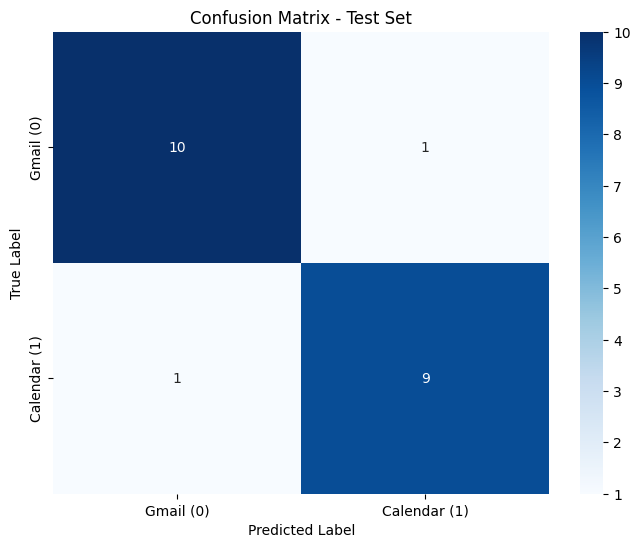


Misclassified Examples from Test Set (2 total):
  Query: 'Where's my latest message?'
  True: Gmail (0), Predicted: Calendar (1)

  Query: 'Display appointments tagged as urgent'
  True: Calendar (1), Predicted: Gmail (0)



In [ ]:

# =================================================================
# EVALUATION
# =================================================================

print("\n" + "="*50)
print("EVALUATION RESULTS")
print("="*50)

# Evaluate on validation set
print("\nValidation Set Results:")
eval_results = trainer.evaluate()
for key, value in eval_results.items():
    if isinstance(value, float):
        print(f"{key}: {value:.4f}")

# Evaluate on test set
print("\nTest Set Results:")
test_results = trainer.evaluate(eval_dataset=tokenized_test)
for key, value in test_results.items():
    if isinstance(value, float):
        print(f"{key}: {value:.4f}")

# Detailed analysis on test set
predictions = trainer.predict(tokenized_test)
pred_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# Classification report
target_names = ['Gmail (0)', 'Calendar (1)']
print(f"\nDetailed Classification Report (Test Set):")
print(classification_report(true_labels, pred_labels, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Test Set')
plt.show()

# Analyze misclassified examples
df_test_reset = df_test.reset_index(drop=True)
misclassified_indices = np.where(pred_labels != true_labels)[0]

print(f"\nMisclassified Examples from Test Set ({len(misclassified_indices)} total):")
for i in misclassified_indices:
    print(f"  Query: '{df_test_reset.iloc[i]['text']}'")
    print(f"  True: {target_names[df_test_reset.iloc[i]['label']]}, "
          f"Predicted: {target_names[pred_labels[i]]}")
    print()

In [ ]:

# =================================================================
# PREDICTION FUNCTION
# =================================================================

def classify_query(text, return_probabilities=False):
    """Classify a single query and optionally return probabilities"""
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class_id = torch.argmax(logits, dim=1).item()
        probabilities = torch.softmax(logits, dim=1).squeeze().tolist()
        confidence = probabilities[predicted_class_id]

    predicted_class = target_names[predicted_class_id]

    if return_probabilities:
        return predicted_class, predicted_class_id, confidence, probabilities
    return predicted_class, predicted_class_id, confidence

In [ ]:

# =================================================================
# TEST WITH CUSTOM QUERIES
# =================================================================

print("\n" + "="*50)
print("TESTING WITH CUSTOM QUERIES")
print("="*50)

test_queries = [
    "Find my presentation for next week",  # Expected: Calendar
    "Search for emails from my boss about the budget",  # Expected: Gmail
    "What's up for today?",  # Ambiguous, likely Calendar
    "Did I get a response to my job application email?",  # Expected: Gmail
    "Team lunch on Friday",  # Expected: Calendar
    "Find the document titled 'Onboarding Checklist'",  # Expected: Gmail
    "When is my next dentist appointment?",  # Expected: Calendar
    "Show me emails with attachments from last week",  # Expected: Gmail
    "Block my calendar for vacation",  # Expected: Calendar
    "Reply to Sarah's message about the project",  # Expected: Gmail
]

for query in test_queries:
    pred_class, pred_id, confidence, probs = classify_query(query, return_probabilities=True)
    print(f"Query: '{query}'")
    print(f"Predicted: {pred_class} (Confidence: {confidence:.4f})")
    print(f"Probabilities: Gmail: {probs[0]:.4f}, Calendar: {probs[1]:.4f}")
    print("-" * 50)


TESTING WITH CUSTOM QUERIES
Query: 'Find my presentation for next week'
Predicted: Calendar (1) (Confidence: 0.7038)
Probabilities: Gmail: 0.2962, Calendar: 0.7038
--------------------------------------------------
Query: 'Search for emails from my boss about the budget'
Predicted: Gmail (0) (Confidence: 0.7546)
Probabilities: Gmail: 0.7546, Calendar: 0.2454
--------------------------------------------------
Query: 'What's up for today?'
Predicted: Calendar (1) (Confidence: 0.7922)
Probabilities: Gmail: 0.2078, Calendar: 0.7922
--------------------------------------------------
Query: 'Did I get a response to my job application email?'
Predicted: Gmail (0) (Confidence: 0.5504)
Probabilities: Gmail: 0.5504, Calendar: 0.4496
--------------------------------------------------
Query: 'Team lunch on Friday'
Predicted: Calendar (1) (Confidence: 0.7573)
Probabilities: Gmail: 0.2427, Calendar: 0.7573
--------------------------------------------------
Query: 'Find the document titled 'Onboardi